In [29]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score
from ml_utils import graph

%pylab inline
pylab.rcParams['figure.figsize'] = (15,9)

out_dir = '../../papi_output_opt/'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Populating the interactive namespace from numpy and matplotlib


/usr/lib/python3/dist-packages/IPython/core/magics/pylab.py:161: UserWarning:

pylab import has clobbered these variables: ['plot']
`%matplotlib` prevents importing * from pylab and numpy



In [30]:
def aggregate(df):
    return df.groupby(['alg','run'])[df.columns[2:]].min()

In [16]:
def load_data(files, scaler=None):
    paths = [out_dir + p for p in files]

    dfs_O0 = [pd.read_csv(path + '_O0.csv', error_bad_lines=False) for path in paths]
    df_O0 = pd.concat(dfs_O0)
    df_O0 = aggregate(df_O0)
    print(df_O0.shape)
    
    dfs_O3 = [pd.read_csv(path + '_O3.csv', error_bad_lines=False) for path in paths]
    df_O3 = pd.concat(dfs_O3)
    df_O3 = df_O3[['alg', 'run', 'time_O3']]
    df_O3 = aggregate(df_O3)
    print(df_O3.shape)
    
    df = df_O0.merge(df_O3, left_index=True, right_index=True)
    df = df.loc[df['time_O3'] > 1]
    
    for col in df.columns:
        if col[:4] == 'PAPI' and col != 'PAPI_TOT_INS':
            df[col] = df[col].astype(float).div(df['PAPI_TOT_INS'], axis=0)
    df['PAPI_TOT_INS'] = 1
    df = df.dropna()
    
    df['speedup'] = df['time_O0'] / df['time_O3']

    cols = sorted(list(df.columns.values))
    df = df[cols]

    x = df.drop(['time_O0', 'time_O3', 'speedup'],axis=1).as_matrix()
    y = df['speedup'].as_matrix()
    
    if scaler is None:
        scaler = RobustScaler(quantile_range=(10,90))
        #scaler = StandardScaler()
        x = scaler.fit_transform(x)
    else:
        x = scaler.transform(x)
        
    pca = PCA(n_components=2)
    pca.fit(x)
    x2 = pca.transform(x)
        
    lim = int(len(x2)*2/3)
    X_train = x2[:lim]
    X_test = x2[lim:]
    y_train = y[:lim]
    y_test = y[lim:]

    print(df.shape)
    
    return X_train, X_test, y_train, y_test, df, scaler

In [31]:
X_train, X_test, y_train, y_test, df, scaler = load_data(['o1', 'o2', 'o3'])

(6712, 53)
(6707, 1)
(1361, 55)


/usr/lib/python3/dist-packages/ipykernel_launcher.py:29: FutureWarning:

Method .as_matrix will be removed in a future version. Use .values instead.

/usr/lib/python3/dist-packages/ipykernel_launcher.py:30: FutureWarning:

Method .as_matrix will be removed in a future version. Use .values instead.



In [32]:
def build_model():
  model = keras.Sequential([
    keras.layers.Dense(64, activation=tf.nn.relu, input_shape=(X_train.shape[1],)),
    keras.layers.Dense(64, activation=tf.nn.relu),
    keras.layers.Dense(1)
  ])

  optimizer = tf.train.RMSPropOptimizer(0.001)

  model.compile(loss='mse', optimizer=optimizer, metrics=['mae'])
  return model

model = build_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 64)                192       
_________________________________________________________________
dense_8 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 65        
Total params: 4,417
Trainable params: 4,417
Non-trainable params: 0
_________________________________________________________________


In [33]:
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self,epoch,logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 100

# Store training stats
history = model.fit(X_train, y_train, epochs=EPOCHS, validation_split=0.2, verbose=0,
                    callbacks=[PrintDot(), keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)])


..........

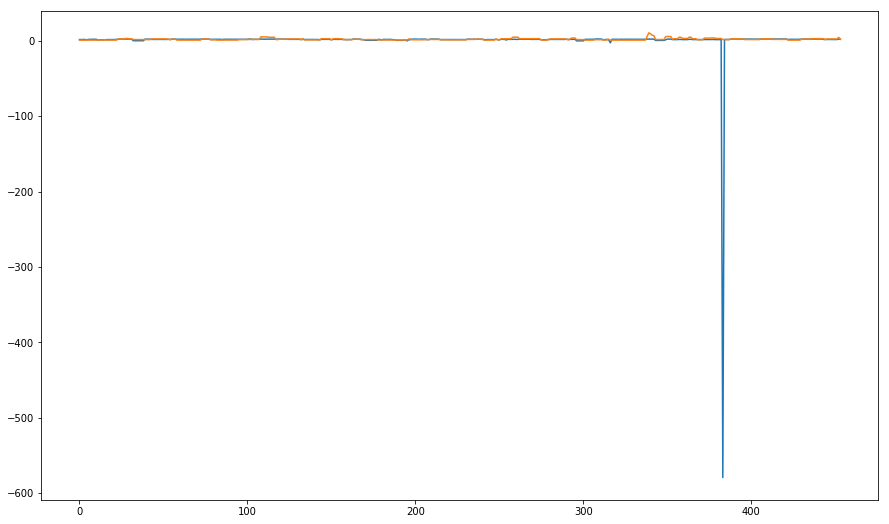

In [34]:
def plot_history(y_test, pred, model):
    plt.figure()
    plt.plot(pred)
    plt.plot(y_test)

pred = model.predict(X_test)
plot_history(y_test, pred, model)

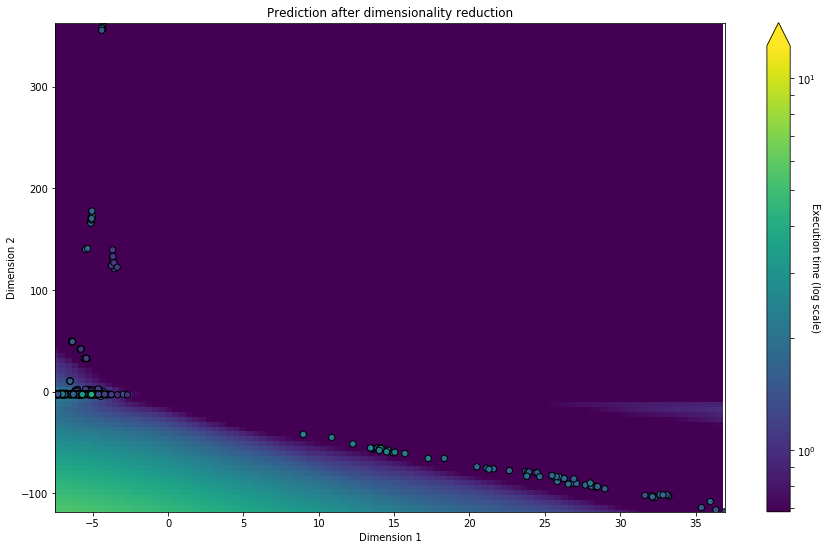

In [21]:
graph(model, X_train, y_train.flatten())

In [22]:
r2_score(y_test, pred)

-0.5184355787226309